In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import optuna 


In [37]:
import warnings
warnings.filterwarnings("ignore")

In [38]:
df = pd.read_csv('../datasets/clean_dataset.csv')

RANDOM_SEED=42

### Algorithm selection

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc,roc_curve,f1_score,accuracy_score,recall_score,precision_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

In [40]:
features = ['close_loans_cnt','federal_district_nm','TraderKey','payment_type_0','payment_type_1','payment_type_2','payment_type_3','payment_type_4','past_billings_cnt','score_1','age','gender','diff_loans']
target = 'bad_flag'

In [41]:

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=RANDOM_SEED)

In [42]:
print(X_train.shape)
print(X_test.shape)

(3316, 13)
(830, 13)


In [43]:
classifiers = [
    KNeighborsClassifier(),
    LogisticRegression(random_state=RANDOM_SEED),
    BaggingClassifier(random_state=RANDOM_SEED),
    GaussianNB(),
    RandomForestClassifier(n_estimators=100,random_state=RANDOM_SEED),
]

Some useful functions:

In [44]:
def class_metrics(y_test,y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("f1 score:", f1)

    return

In [45]:
def plot_cm(cm):
    classes=["bad_flag=0", "bad_flag=1"]

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)

    plt.title('Confusion matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [46]:
def plot_roc(classifier,X_test,y_test):
    y_probs = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)

    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False positives (FPR)')
    plt.ylabel('True positives (TPR)')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.show()

## 1. Experiment 2. Oversampling

#### 1.1) SMOTE without cross-validation. Synthetic generation of values for the minority class.

In [47]:
from imblearn.over_sampling import SMOTE

In [48]:
classes = pd.Series(y_train).value_counts()
print("Classes before oversampling:")
print(classes)

Classes before oversampling:
bad_flag
0    2984
1     332
Name: count, dtype: int64


In [49]:
smote = SMOTE(sampling_strategy='auto', random_state=RANDOM_SEED)

X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

# Contar las clases después del oversampling
n_classes = pd.Series(y_train_oversampled).value_counts()
print("Number of classes after oversampling:")
print(n_classes)

Number of classes after oversampling:
bad_flag
0    2984
1    2984
Name: count, dtype: int64


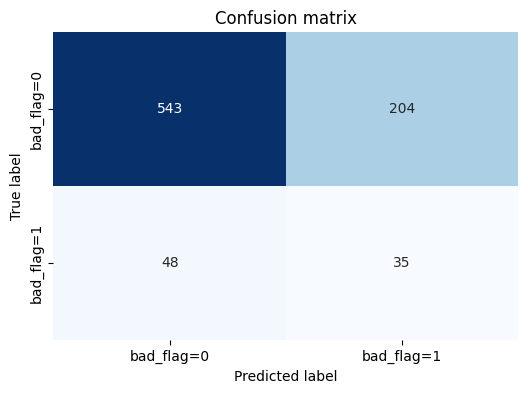

KNeighborsClassifier
Accuracy: 0.6963855421686747
Precision: 0.14644351464435146
Recall: 0.42168674698795183
f1 score: 0.21739130434782608


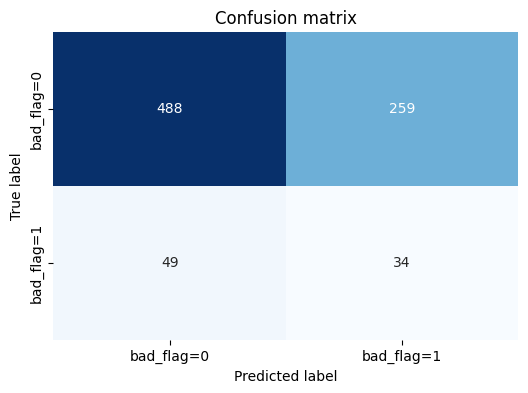

LogisticRegression
Accuracy: 0.6289156626506024
Precision: 0.11604095563139932
Recall: 0.40963855421686746
f1 score: 0.18085106382978727


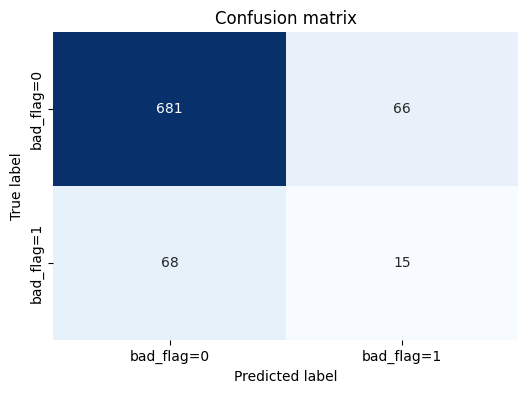

BaggingClassifier
Accuracy: 0.8385542168674699
Precision: 0.18518518518518517
Recall: 0.18072289156626506
f1 score: 0.1829268292682927


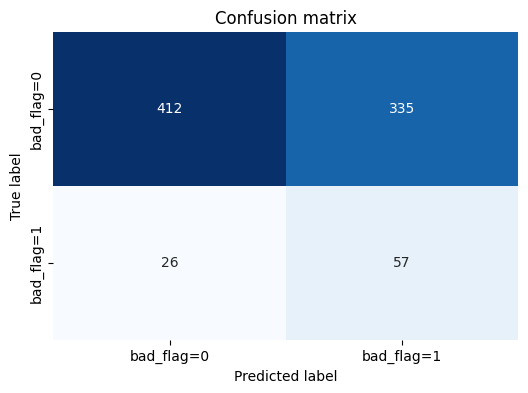

GaussianNB
Accuracy: 0.5650602409638554
Precision: 0.14540816326530612
Recall: 0.6867469879518072
f1 score: 0.24


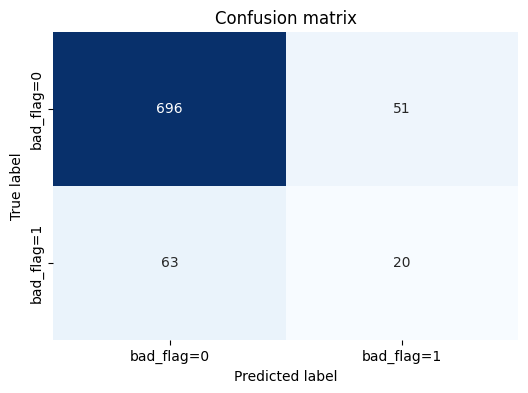

RandomForestClassifier
Accuracy: 0.8626506024096385
Precision: 0.28169014084507044
Recall: 0.24096385542168675
f1 score: 0.25974025974025977


In [50]:
for classifier in classifiers:
    classifier.fit(X=X_train_oversampled, y=y_train_oversampled)
    y_pred = classifier.predict(X=X_test)
    cm = confusion_matrix(y_test, y_pred)
    plot_cm(cm)
    
    print(classifier.__class__.__name__)
    class_metrics(y_test=y_test,y_pred=y_pred)

The best f1 score has been obtained by the RandomForest algorithm so we are going to use the hyperparameter optimization:

In [51]:
def objective2(trial: optuna.Trial):

    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    # min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    # min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)


    RFC = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        # min_samples_split=min_samples_split,
        # min_samples_leaf=min_samples_leaf,
        random_state=RANDOM_SEED
    )

    classifier = RFC.fit(X=X_train_oversampled, y=y_train_oversampled)
    y_pred = classifier.predict(X=X_test)

    return f1_score(y_true=y_test, y_pred=y_pred)

In [52]:
sampler=optuna.samplers.TPESampler()
study = optuna.create_study(direction="maximize",study_name="RandomForest_SMOTE",sampler=sampler)
study.optimize(objective2, n_trials=20)

print("Best F1-score: ", study.best_value)
print("Best params: ", study.best_params)

[I 2023-08-07 17:33:25,397] A new study created in memory with name: RandomForest_SMOTE
[I 2023-08-07 17:33:26,870] Trial 0 finished with value: 0.32941176470588235 and parameters: {'n_estimators': 132, 'max_depth': 8}. Best is trial 0 with value: 0.32941176470588235.
[I 2023-08-07 17:33:27,668] Trial 1 finished with value: 0.3288590604026846 and parameters: {'n_estimators': 155, 'max_depth': 3}. Best is trial 0 with value: 0.32941176470588235.
[I 2023-08-07 17:33:28,442] Trial 2 finished with value: 0.30476190476190473 and parameters: {'n_estimators': 51, 'max_depth': 12}. Best is trial 0 with value: 0.32941176470588235.
[I 2023-08-07 17:33:28,565] Trial 3 finished with value: 0.35797665369649806 and parameters: {'n_estimators': 13, 'max_depth': 7}. Best is trial 3 with value: 0.35797665369649806.
[I 2023-08-07 17:33:28,668] Trial 4 finished with value: 0.3017543859649123 and parameters: {'n_estimators': 21, 'max_depth': 3}. Best is trial 3 with value: 0.35797665369649806.
[I 2023-08-

Best F1-score:  0.35797665369649806
Best params:  {'n_estimators': 13, 'max_depth': 7}


In [53]:
study.best_params

{'n_estimators': 13, 'max_depth': 7}

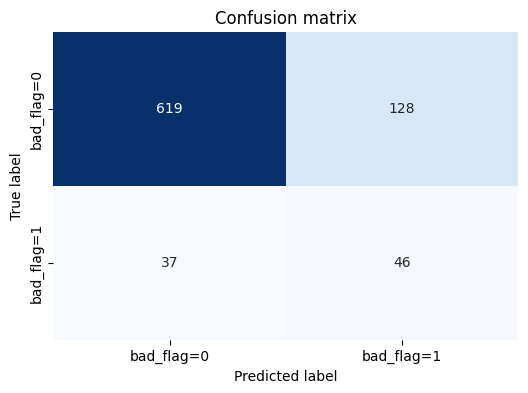

Accuracy: 0.8012048192771084
Precision: 0.26436781609195403
Recall: 0.5542168674698795
f1 score: 0.35797665369649806


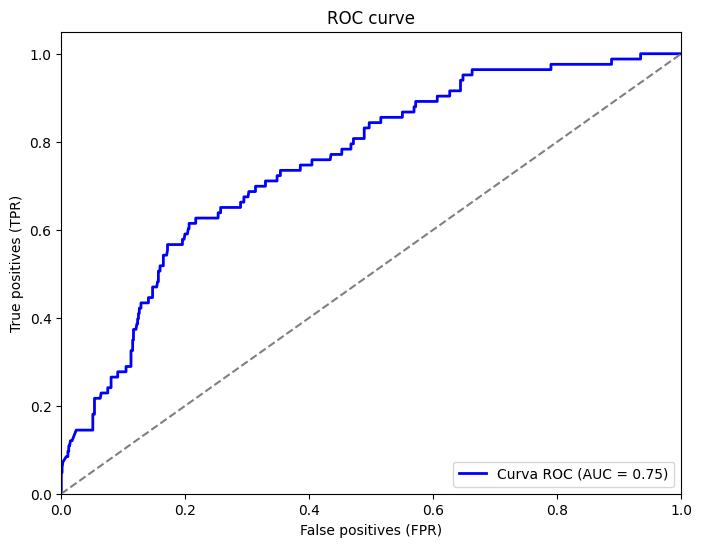

In [54]:

clf2 = RandomForestClassifier(**study.best_params, random_state=RANDOM_SEED)
clf2.fit(X_train_oversampled, y_train_oversampled)

y_pred = clf2.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plot_cm(cm)

class_metrics(y_test=y_test,y_pred=y_pred)

plot_roc(clf2,X_test,y_test)


### 1.2) SMOTE with cross-validation

In [55]:
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, StratifiedKFold


print('Length of X (train): {} | Length of y (train): {}'.format(len(X_train), len(y_train)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(X_test), len(y_test)))


accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []


rand_for_sm=RandomForestClassifier()

rand_for_params = {
    'n_estimators': [50, 100, 150, 200], 
    'max_depth': [10, 20, 30],  
}
rand_rand_for = RandomizedSearchCV(RandomForestClassifier(), rand_for_params, n_iter=4)

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train, test in sss.split(X_train, y_train):
    pipeline = make_pipeline(SMOTE(sampling_strategy='minority'), rand_rand_for) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(X_train.iloc[train], y_train.iloc[train])
    best_est = rand_rand_for.best_estimator_
    prediction = best_est.predict(X_train.iloc[test])
    
    accuracy_lst.append(pipeline.score(X_train.iloc[test], y_train.iloc[test]))
    precision_lst.append(precision_score(y_train.iloc[test], prediction))
    recall_lst.append(recall_score(y_train.iloc[test], prediction))
    f1_lst.append(f1_score(y_train.iloc[test], prediction))
    # auc_lst.append(roc_auc_score(y_train[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 3316 | Length of y (train): 3316
Length of X (test): 830 | Length of y (test): 830
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.8739405586145488
precision: 0.34809514734043034
recall: 0.2801899592944369
f1: 0.3080199078252413
---------------------------------------------------------------------------------------------------------------------------------------


In [56]:
rand_rand_for.best_estimator_

RandomForestClassifier(max_depth=30, n_estimators=150)

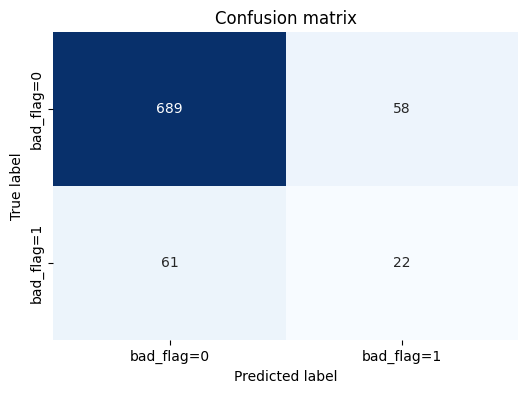

Accuracy: 0.8566265060240964
Precision: 0.275
Recall: 0.26506024096385544
f1 score: 0.26993865030674846


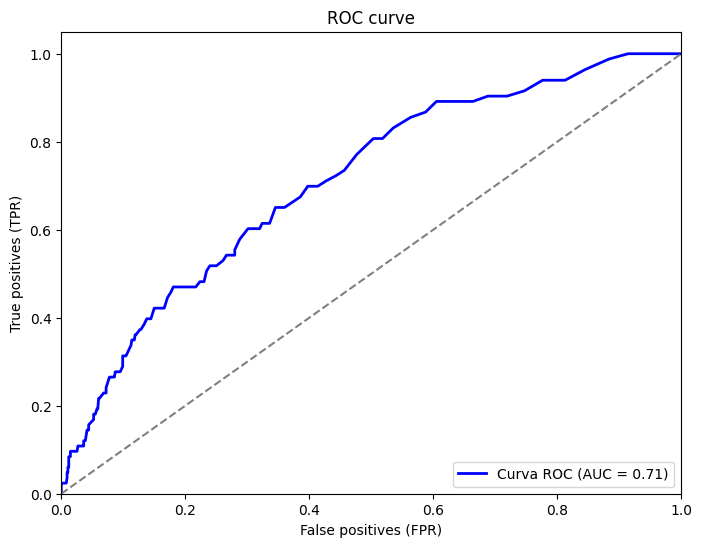

In [57]:
y_pred_fin=rand_rand_for.predict(X_test)

cm = confusion_matrix(y_test, y_pred_fin)
plot_cm(cm)

class_metrics(y_test=y_test,y_pred=y_pred_fin)

plot_roc(rand_rand_for,X_test,y_test)
